In [214]:
import pandas as pd
import numpy as np
import re
import json

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

from datetime import datetime
import nltk
from nltk.stem.snowball import SnowballStemmer
from textblob import TextBlob
stemmer = SnowballStemmer('english')
stopwords = nltk.corpus.stopwords

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [215]:
def tokenize_and_stem(text):
    tokens = [word for word in TextBlob(text).words]
    filtered_tokens = [re.sub('[^a-zA-Z]','',w) for w in tokens]
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def error_rate(predictions, actuals):
    return np.mean(predictions != actuals)

def document_title(doc):
    if doc == 'null' or (type(doc)==float and np.isnan(doc)):
        return ''
    else:
        return json.loads(doc).get('title','')  

In [216]:
raw = pd.read_csv('data/boxer.csv')
raw['bill_title'] = raw['bill'].apply(document_title)
raw['amendment_title'] = raw['amendment'].apply(document_title)
raw['text'] = raw['question'].str.cat(raw['bill_title'],sep=' ')
raw['text'] = raw['text'].str.cat(raw['amendment_title'],sep=' ')
raw['text'] = raw['text'].apply(lambda x: re.sub("\d+", "", x))
len(raw)

5236

In [249]:
tfidf = TfidfVectorizer(max_df=0.9,
                        max_features=10000,
                        stop_words='english',
                        use_idf=True, tokenizer=None, ngram_range=(1,3))

In [250]:
tfidf_matrix = tfidf.fit_transform(raw['text'])
tfidf.get_feature_names()

['ability',
 'abortion',
 'abortion ban',
 'abortion ban act',
 'abortion notification',
 'abortion notification act',
 'abrams',
 'absent',
 'absent senators',
 'abuse',
 'abuse heroin',
 'abuse heroin use',
 'abuse prevention',
 'abuse prevention consumer',
 'abusive',
 'abusive financial',
 'abusive financial services',
 'access',
 'access affordable',
 'access affordable pharmaceuticals',
 'access affordable reliable',
 'access care',
 'access care rural',
 'access chip',
 'access chip reauthorization',
 'access health',
 'access health care',
 'access local',
 'access local television',
 'access preventive',
 'access preventive mental',
 'access purposes',
 'access veterans',
 'access veterans medical',
 'accompany',
 'accompany act',
 'accompany act authorize',
 'account',
 'account central',
 'account central intelligence',
 'account employees',
 'account employees shared',
 'account purposes',
 'account purposes determining',
 'accountability',
 'accountability act',
 'accounta

In [219]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, 
                                                    raw['vote'].values, 
                                                    test_size=0.2)

In [220]:
clf = LogisticRegression(penalty='l2',
                        C=1e-1)
clf.fit(x_train,y_train)
predictions = clf.predict(x_test)
print('Error Rate:',error_rate(predictions, y_test))
print('f1 score:', f1_score(y_test,predictions))

rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train,y_train)
predictions = clf.predict(x_test)
print('Error Rate:',error_rate(predictions, y_test))
print('f1 score:', f1_score(y_test,predictions))

Error Rate: 0.373091603053
f1 score: 0.76740035693
Error Rate: 0.373091603053
f1 score: 0.76740035693


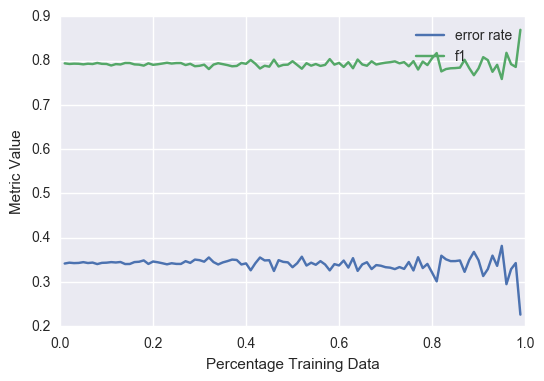

In [221]:
nrange = np.linspace(0.01,0.99,99)
errors = []
f1s = []
for n in nrange:
    x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, 
                                                    raw['vote'].values, 
                                                    train_size=n)
    clf = LogisticRegression(penalty='l2', C=1e-1)
    clf.fit(x_train,y_train)
    predictions = clf.predict(x_test)
    errors.append(error_rate(y_test, predictions))
    f1s.append(f1_score(y_test, predictions))
    
plt.plot(nrange,errors,label='error rate')
plt.plot(nrange,f1s,label='f1')
plt.xlabel('Percentage Training Data')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [222]:
k=100
crange = np.logspace(-10,10,21)
errors = []
test_errors = []
f1s = []
test_f1s = []
n = len(y_train)
for c in crange:
    kfold = KFold(n,k)
    error = []
    f1 = []
    for train_index, test_index in kfold:
        X_cross_train, X_val = x_train[train_index], x_train[test_index]
        Y_cross_train, Y_val = y_train[train_index], y_train[test_index]
    
        clf = LogisticRegression(penalty='l2',C=c)
        clf.fit(X_cross_train,Y_cross_train)
        predictions = clf.predict(X_val)
        error.append(error_rate(Y_val, predictions))
        f1.append(f1_score(Y_val, predictions))
        
    print(c,':',np.mean(error),':',np.mean(f1))
    errors.append(np.mean(error))
    f1s.append(np.mean(f1))

1e-10 : 0.343793363499 : 0.79024837533
1e-09 : 0.343793363499 : 0.79024837533
1e-08 : 0.343793363499 : 0.79024837533
1e-07 : 0.343793363499 : 0.79024837533
1e-06 : 0.343793363499 : 0.79024837533
1e-05 : 0.343793363499 : 0.79024837533
0.0001 : 0.343793363499 : 0.79024837533
0.001 : 0.343793363499 : 0.79024837533
0.01 : 0.343793363499 : 0.79024837533
0.1 : 0.333544494721 : 0.790462811047
1.0 : 0.316923076923 : 0.787239954779
10.0 : 0.31479638009 : 0.783170284727
100.0 : 0.318269230769 : 0.778818712722
1000.0 : 0.316904223228 : 0.778845618794
10000.0 : 0.316704374057 : 0.778944296198
100000.0 : 0.31689668175 : 0.778780249718
1000000.0 : 0.31689668175 : 0.778780249718
10000000.0 : 0.317092760181 : 0.778634680098
100000000.0 : 0.317092760181 : 0.778634680098
1000000000.0 : 0.31689668175 : 0.778780249718
10000000000.0 : 0.31689668175 : 0.778780249718


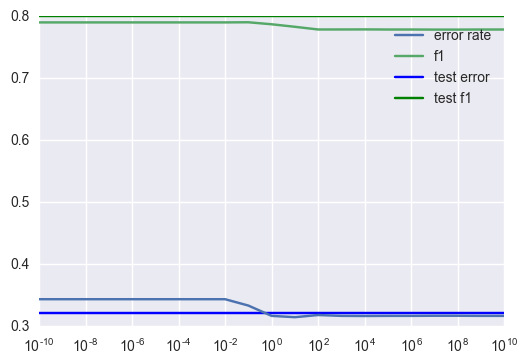

In [223]:
test_predictions = clf.predict(x_test)
test_error = error_rate(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)
plt.semilogx(crange,errors,label='error rate')
plt.semilogx(crange,f1s,label='f1')
plt.hlines(y=test_error,xmin=min(crange),xmax=max(crange),
           label='test error',color='b')
plt.hlines(y=test_f1,xmin=min(crange),xmax=max(crange),
          label='test f1', color='g')
plt.legend()
plt.show()

### Try again but with a RF

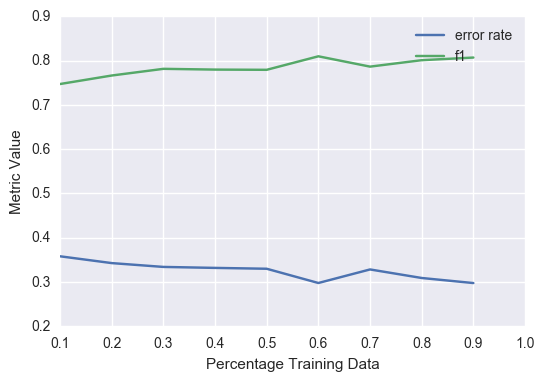

In [180]:
nrange = np.linspace(0.1,0.9,9)
errors = []
f1s = []
for n in nrange:
    x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, 
                                                    raw['vote'].values, 
                                                    train_size=n)
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(x_train,y_train)
    predictions = clf.predict(x_test)
    errors.append(error_rate(y_test, predictions))
    f1s.append(f1_score(y_test, predictions))
    
plt.plot(nrange,errors,label='error rate')
plt.plot(nrange,f1s,label='f1')
plt.xlabel('Percentage Training Data')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [185]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, 
                                                    raw['vote'].values, 
                                                    train_size=0.2)
k=10
nrange = np.logspace(0,4,5,dtype='int64')
errors = []
f1s = []
N = len(y_train)
for n in nrange:
    kfold = KFold(N,k)
    error = []
    f1 = []
    for train_index, test_index in kfold:
        X_cross_train, X_val = x_train[train_index], x_train[test_index]
        Y_cross_train, Y_val = y_train[train_index], y_train[test_index]
    
        clf = RandomForestClassifier(n_estimators=n)
        clf.fit(X_cross_train,Y_cross_train)
        predictions = clf.predict(X_val)
        error.append(error_rate(Y_val, predictions))
        f1.append(f1_score(Y_val, predictions))
        
    print(n,':',np.mean(error),':',np.mean(f1))
    errors.append(np.mean(error))
    f1s.append(np.mean(f1))

1000
1 : 0.339981684982 : 0.770025633469
10 : 0.314304029304 : 0.797209118724
100 : 0.305677655678 : 0.803425795591
1000 : 0.306639194139 : 0.802829518932
10000 : 0.308543956044 : 0.801917101108


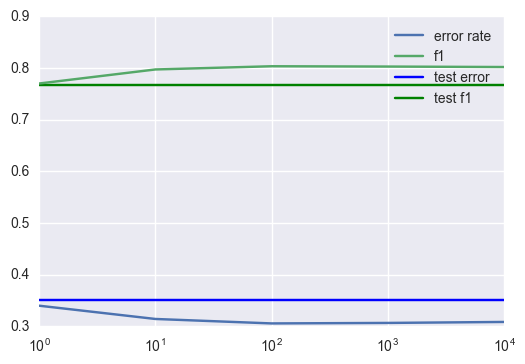

In [186]:
test_predictions = clf.predict(x_test)
test_error = error_rate(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)
plt.semilogx(nrange,errors,label='error rate')
plt.semilogx(nrange,f1s,label='f1')
plt.hlines(y=test_error,xmin=min(nrange),xmax=max(nrange),
           label='test error',color='b')
plt.hlines(y=test_f1,xmin=min(nrange),xmax=max(nrange),
          label='test f1', color='g')
plt.legend()
plt.show()

## Try with k nearest neighbors

In [251]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, 
                                                    raw['vote'].values, 
                                                    test_size=0.2)

In [252]:
clf =  KNeighborsClassifier(n_neighbors=10,
                            weights='distance')
clf.fit(x_train,y_train)
predictions = clf.predict(x_test)
print('Error Rate:',error_rate(predictions, y_test))
print('f1 score:', f1_score(y_test,predictions))

Error Rate: 0.289122137405
f1 score: 0.783106657122


In [253]:
k=100
nrange = np.arange(1,211,10)
errors = []
f1s = []
N = len(y_train)
for n in nrange:
    kfold = KFold(N, k)
    error = []
    f1 = []
    for train_index, test_index in kfold:
        X_cross_train, X_val = x_train[train_index], x_train[test_index]
        Y_cross_train, Y_val = y_train[train_index], y_train[test_index]
    
        clf = KNeighborsClassifier(n_neighbors=n,
                                   weights='distance')
        clf.fit(X_cross_train,Y_cross_train)
        predictions = clf.predict(X_val)
        error.append(error_rate(Y_val, predictions))
        f1.append(f1_score(Y_val, predictions))
        
    print(n,':',np.mean(error),':',np.mean(f1))
    errors.append(np.mean(error))
    f1s.append(np.mean(f1))

1 : 0.314483159117 : 0.751530662454
11 : 0.29556329849 : 0.783227808342
21 : 0.28818815331 : 0.790553227752
31 : 0.288885017422 : 0.7913998229
41 : 0.283641114983 : 0.79755840189
51 : 0.281492450639 : 0.801480490391
61 : 0.28218931475 : 0.80195124148
71 : 0.279576074332 : 0.80471723924
81 : 0.280516840883 : 0.804339592655
91 : 0.281463414634 : 0.804077433259
101 : 0.28193960511 : 0.804046404178
111 : 0.280987224158 : 0.804670888373
121 : 0.279790940767 : 0.805772768727
131 : 0.280981416957 : 0.805224888273
141 : 0.281701509872 : 0.804940307032
151 : 0.282415795587 : 0.805189244147
161 : 0.282177700348 : 0.805789524021
171 : 0.281945412311 : 0.806297625039
181 : 0.281707317073 : 0.806460074733
191 : 0.281945412311 : 0.806265491329
201 : 0.281945412311 : 0.806470947251


In [254]:
raw.head()


,member_id,chamber,congress,number,date,year,category,requires,vote_id,question,bill,amendment,vote,bill_title,amendment_title,text
0,S223,s,106.0,1.0,2000-02-01T14:21:00-05:00,2000,procedural,1/2,s1-106.2000,On the Motion to Table S.Amdt. 2538 to S. 625 ...,"{""title"": ""Bankruptcy Judgeship Act of 1999"", ...","{""type"": ""s"", ""number"": 2538, ""purpose"": ""To m...",0.0,Bankruptcy Judgeship Act of 1999,,On the Motion to Table S.Amdt. to S. (Bankru...
1,S223,s,106.0,10.0,2000-02-10T14:03:00-05:00,2000,nomination,1/2,s10-106.2000,"On the Nomination PN597: Thomas L. Ambro, of D...",null,null,1.0,,,"On the Nomination PN: Thomas L. Ambro, of Dela..."
2,S223,s,106.0,100.0,2000-05-16T17:56:00-04:00,2000,procedural,1/2,s100-106.2000,On the Motion to Table S.Amdt. 3148 to S. 2521...,"{""title"": ""Military Construction Appropriation...","{""type"": ""s"", ""number"": 3148, ""purpose"": ""To e...",1.0,"Military Construction Appropriations Act, 2001",,On the Motion to Table S.Amdt. to S. (Milita...
3,S223,s,106.0,101.0,2000-05-16T18:25:00-04:00,2000,procedural,1/2,s101-106.2000,On the Motion to Proceed PN986: Jose Antonio P...,null,null,1.0,,,On the Motion to Proceed PN: Jose Antonio Pere...
4,S223,s,106.0,102.0,2000-05-17T14:55:00-04:00,2000,procedural,1/2,s102-106.2000,On the Decision of the Chair S.Amdt. 3150 to S...,"{""title"": ""Military Construction Appropriation...","{""type"": ""s"", ""number"": 3150, ""purpose"": ""To e...",1.0,"Military Construction Appropriations Act, 2001",,On the Decision of the Chair S.Amdt. to S. (...
